#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, 

<b><u>Цель:</u></b> Построить модель для предсказания количество заказов такси на следующий час

<b><u>Задача:</u></b>

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.
5. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [39]:
# !pip install python-pip -U -q
# !pip install numba==0.59.1 -q

# !pip install numpy==1.23.1 -q

# !pip install matplotlib -U -q
# !pip install scikit-learn -U -q 
# !pip install pandas==2.2.2 -q
# !pip install jinja2==3.1.2 -q


In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import randint

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit,
    GridSearchCV
)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler
)
from sklearn.feature_selection import (
    SelectKBest,
    f_classif
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    root_mean_squared_error
)
RANDOM_STATE = 42

In [41]:
project_path_01 = "C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Taxi_orders\\"
project_path_02 = "/datasets/"

In [42]:
if os.path.exists(project_path_01):
    data = pd.read_csv(project_path_01 + 'taxi.csv')
elif os.path.exists(project_path_02):
    data = pd.read_csv(project_path_02 + 'taxi.csv')
else:
    print("Smth wrong")

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [44]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


### Выводы. Загрузка.

- данные размером (26496, 2)
- нет пропусков
- данные отсортированы по увеличению индекса
- столбец `datetime` - дата закзаза, тип данных object. 
- столбец `num_orders` - количество заказов, тип данных int64

### Обработка и ресемплирование

In [45]:
data['datetime'] = pd.to_datetime(data['datetime'])
df = data.set_index('datetime')
df.sort_index(inplace=True)

In [46]:
df.index.is_monotonic_increasing

True

In [47]:
df = df.resample('h').sum()

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Выводы. Обработка и ресемплирование

- `datetime` - данные переведены в формат datetime.
- установлен индекс `datetime`
- индекс отсортирован на увеличение
- данные проверерны на монотонность
- ресемплинг данных на 1 час
- новый размер данных (4416, 1), индекс дата

## Анализ

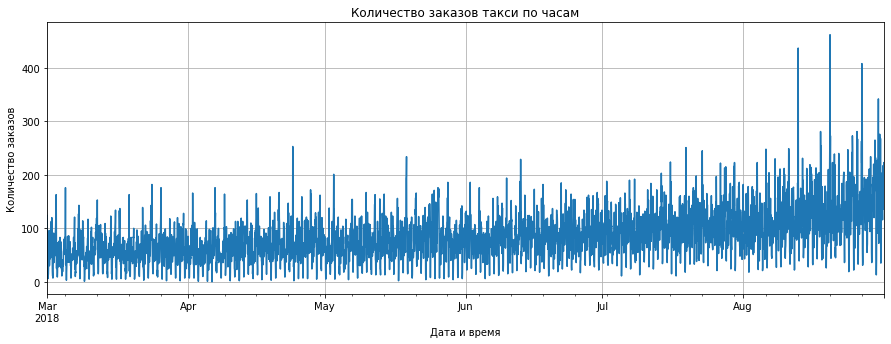

In [49]:
plt.figure(figsize=(15, 5))
df['num_orders'].plot(title='Количество заказов такси по часам')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

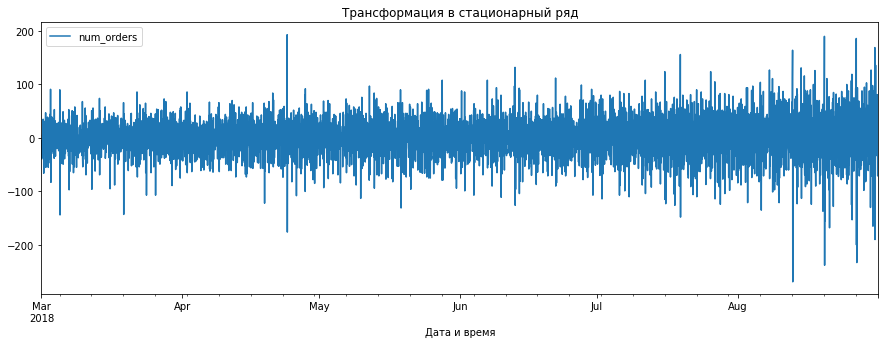

In [50]:
(df - df.shift()).plot(figsize=(15,5))
plt.title('Трансформация в стационарный ряд')
plt.xlabel('Дата и время');

In [51]:
decomposition = seasonal_decompose(df['num_orders'], period=24*7)

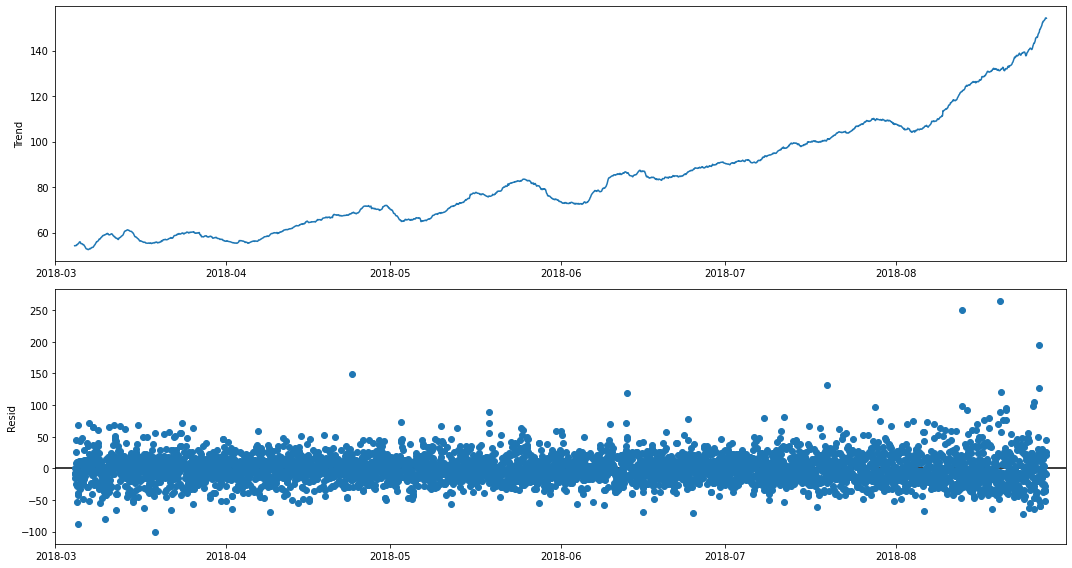

In [52]:
fig = decomposition.plot(observed=False, seasonal=False)
fig.set_size_inches((15, 8))
fig.tight_layout()
plt.show()

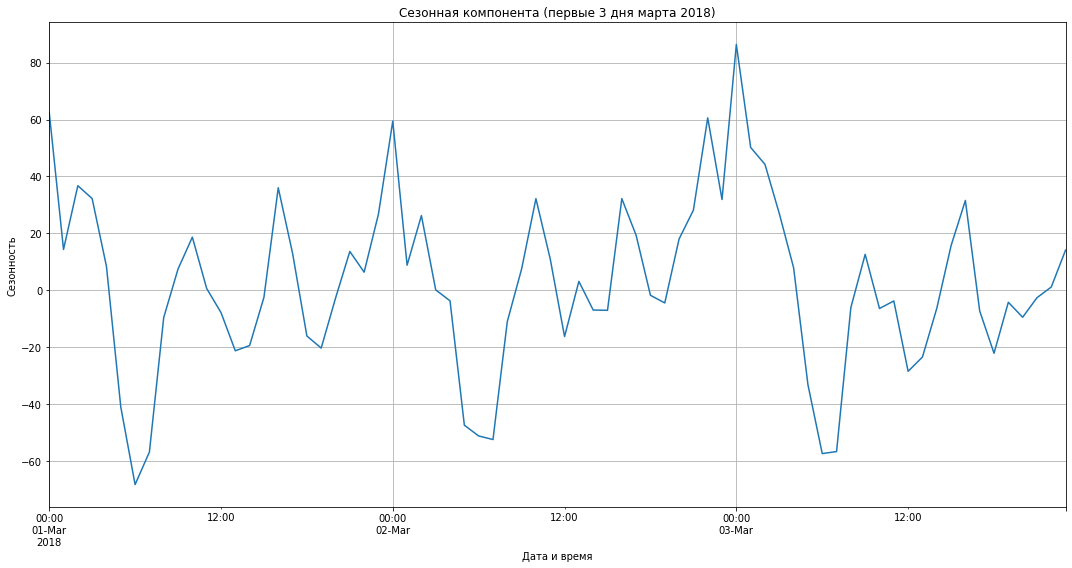

In [53]:
plt.figure(figsize=(15, 8))
decomposition.seasonal['2018-03-01':'2018-03-03'].plot(
    title='Сезонная компонента (первые 3 дня марта 2018)')
plt.xlabel('Дата и время')
plt.ylabel('Сезонность')
plt.grid()

plt.tight_layout()
plt.show()

### Выводы. Анализ данных.

- временной ряд не стационарный (увелчение среднего и отклонения к концу периода)
- явный восходящий тренд на увеличение количества заказов с марта по август
- сезонный компонент: увеличение количества заказов с 6:00 до 00:00 с дальнейшим резким падением.

## Обучение

### Создание признаков

In [76]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    #df['day'] = df.index.day
    #df['month'] = df.index.month
    #df['weekofyear'] = df.index.isocalendar().week
    for i in [1, 2, 3, 24, 48, 24*7]:
        df[f'lag_{i}'] = df['num_orders'].shift(i)
    for window in [3, 7, 24, 24*7]:
        df[f'rolling_mean_{window}'] = df['num_orders'].shift().rolling(window).mean()
    return df


In [78]:
df_mod = create_features(df)

In [79]:
print(df_mod.shape)
df_mod = df_mod.dropna()
print(df_mod.shape)

(4416, 13)
(4248, 13)


In [80]:
df_mod.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_24,lag_48,lag_168,rolling_mean_3,rolling_mean_7,rolling_mean_24,rolling_mean_168
datetime,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,94.0,127.0,108.0,100.0,42.0,124.0,109.666667,86.000000,60.041667,54.226190
2018-03-08 01:00:00,78,1,3,143.0,94.0,127.0,121.0,75.0,85.0,121.333333,99.571429,61.833333,54.339286
2018-03-08 02:00:00,65,2,3,78.0,143.0,94.0,24.0,36.0,71.0,105.000000,96.571429,60.041667,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,66.0,49.0,66.0,95.333333,98.714286,61.750000,54.261905
2018-03-08 04:00:00,60,4,3,68.0,65.0,78.0,73.0,30.0,43.0,70.333333,97.571429,61.833333,54.273810


#### Новые признаки
1. из даты выделены
 - 'hour'
 - 'dayofweek'
 - 'day'
 - 'month'
 - 'weekofyear'
2. сместили ряд и выделили в отдельные признаки: [1, 2, 3, 24, 48, 24*7]
3. добавили скользящие средние: [3, 7, 24, 24*7]

### Обучение моделей и подбор гиперпараметров

In [81]:
X = df_mod.drop('num_orders', axis=1)
y = df_mod['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)

In [82]:
pipe_final = Pipeline(
    [   
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif)),
        ('models', LinearRegression())
    ]
)

In [83]:
param_grid = [
    {
        'models': [LinearRegression()],
        'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'feature_selection__k': range(2, 14)
    },
#     {
#         'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
#         'models__n_estimators': range(50, 100),
#         'models__max_depth': [None, 10, 20],
#         'models__min_samples_split': range(2, 5),
#         'models__min_samples_leaf': range(1, 10),
#         'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
#         'feature_selection__k': range(2, 14)
#     },
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': range(5, 10),
        'models__max_depth': range(5, 20),
        'feature_selection__k': range(2, 14)
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_iter = 20,
    verbose=1,
    n_jobs=-1
)

In [84]:
tscv = TimeSeriesSplit(n_splits=2)

In [85]:
grid_search = GridSearchCV(
    estimator=pipe_final, 
    param_grid=param_grid,
    cv=tscv, 
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

In [86]:
#randomized_search.fit(X_train, y_train)

In [87]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 936 candidates, totalling 1872 fits


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=13 is greater than n_features=12. All the features will be returned.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=13 is greater than n_features=12. All the features will be returned.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=13 is greater than n_features=12. All the features will be returned.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=13 is greater than n_features=12. All the features will be returned.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=13 is greater than n_features=12. All the features will be returned.
  warnings.warn(
/opt/conda/lib/pytho

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection', SelectKBest()),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'feature_selection__k': range(2, 14),
                          'models': [LinearRegression()],
                          'scaler': [StandardScaler(), MinMaxScaler(),
                                     'passthrough']},
                         {'feature_selection__k': range(2, 14),
                          'models': [LGBMRegressor(random_state=42)],
                          'models__max_depth': range(5, 20),
                          'models__num_leaves': range(5, 10)}],
             scoring='neg_root_mean_squared_error', verbose=1)

In [88]:
best_model = grid_search

In [89]:
print(f'RMSE лучшей модели на кросс-валидации:\
      {abs(best_model.best_score_):.2f}')

RMSE лучшей модели на кросс-валидации:      23.69


In [90]:
best_results = {}

for model_params in param_grid:
    model_name = model_params['models'][0].__class__.__name__

    model_indices = [
        i for i, params in enumerate(best_model.cv_results_['params'])
        if params['models'].__class__.__name__ == model_name
    ]
    best_index = model_indices[
        np.argmax([best_model.cv_results_['mean_test_score'][i] for i in model_indices])
    ]
    best_score = best_model.cv_results_['mean_test_score'][best_index]
    best_params = best_model.cv_results_['params'][best_index]
    
    best_results[model_name] = {
        'best_score': best_score,
        'best_params': best_params
    }
for model_name, result in best_results.items():
    print(f"Model: {model_name}")
    print(f"Best Score: {result['best_score']}")
    print(f"Best Params: {result['best_params']}")
    print("-" * 40)

Model: LinearRegression
Best Score: -23.694692116639203
Best Params: {'feature_selection__k': 12, 'models': LinearRegression(), 'scaler': StandardScaler()}
----------------------------------------
Model: LGBMRegressor
Best Score: -23.809653970621966
Best Params: {'feature_selection__k': 8, 'models': LGBMRegressor(random_state=42), 'models__max_depth': 5, 'models__num_leaves': 6}
----------------------------------------


#### Обучение моделей
1. Обучили три модели:
- LinearRegression
- RandomForestRegressor
- LGBMRegressor
2. Лучший результат LinearRegression
- RMSE на кросс-валидации: 21.70

## Тестирование

In [91]:
rmse_test = root_mean_squared_error(y_test, best_model.predict(X_test))
print(f'RMSE лучшей модели на тесте: {rmse_test:.2f}')

RMSE лучшей модели на тесте: 34.92


In [92]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)
print(f'Результат модели Dummy (mean):\
      {np.mean(dummy_reg.predict(X_test)):.2f}')

Результат модели Dummy (mean):      79.56


### Проверка
1. Обучили лучшую модель на тесте:
    - RMSE на тестовой выборке: 35.80
2. Сравнили с Dummy (mean)
    -  Dummy (mean):      79.56

### Визуализация работы модели

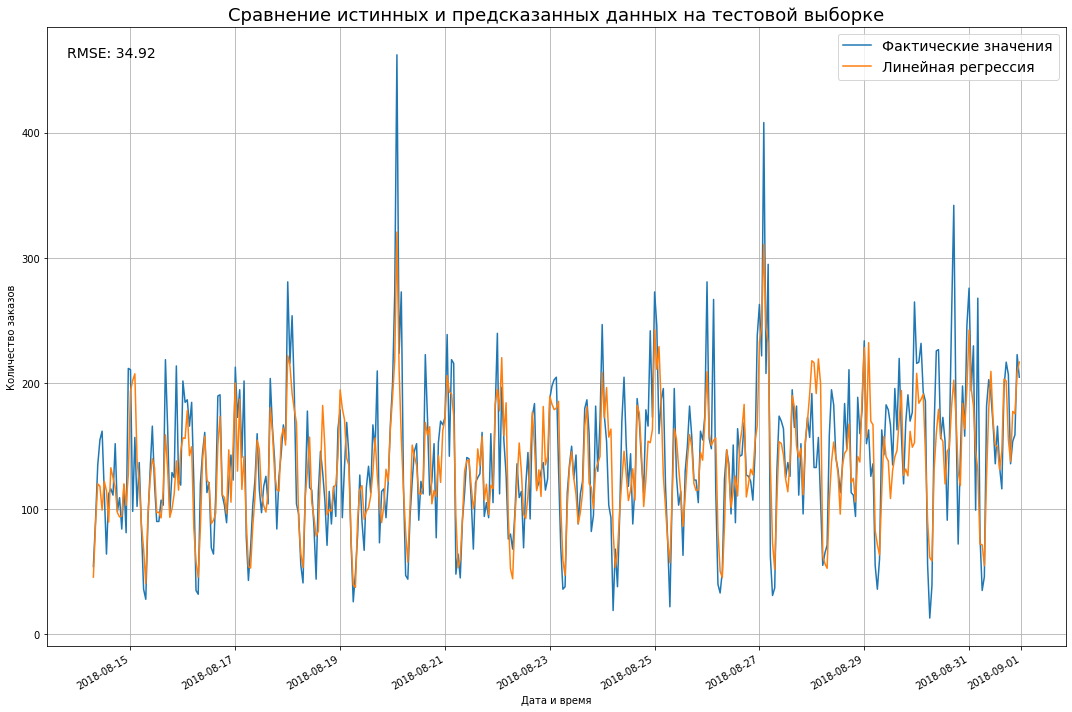

In [93]:
plt.figure(figsize=(15, 10))
plt.plot(y_test.index, y_test, label='Фактические значения')
plt.plot(y_test.index, best_model.predict(X_test), label='Линейная регрессия')
plt.title('Сравнение истинных и предсказанных данных на тестовой выборке', fontsize=18)
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.annotate(f'RMSE: {rmse_test:.2f}', xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [94]:
y_test.index[0]

Timestamp('2018-08-14 07:00:00')

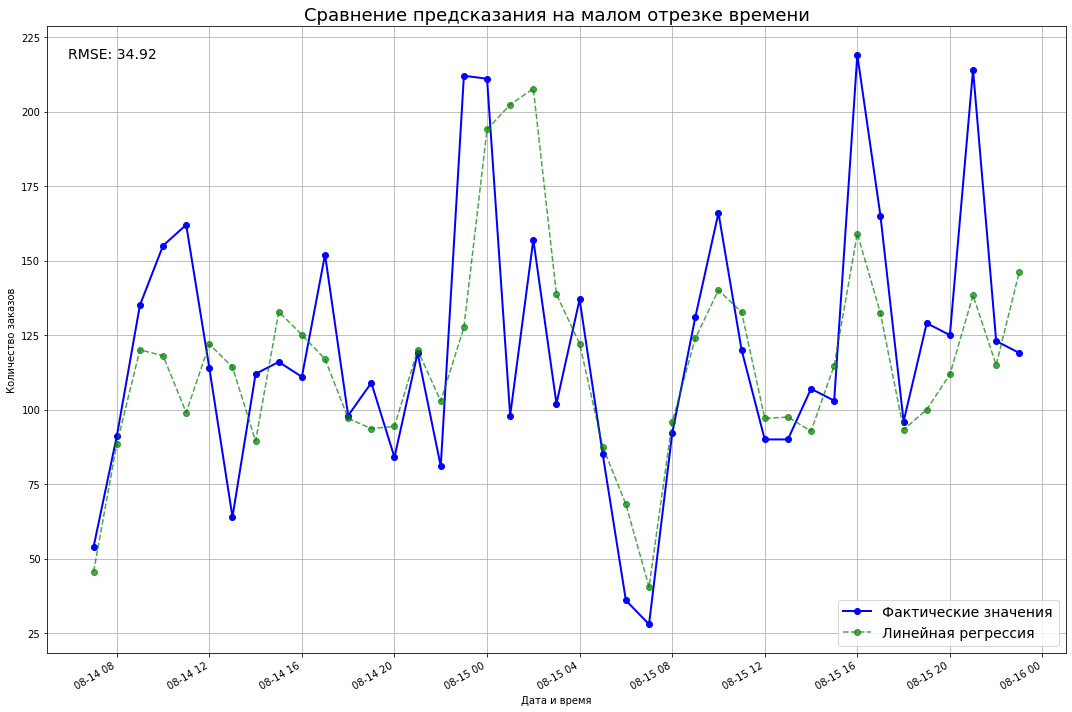

In [95]:
start_date = '2018-08-14'
end_date = '2018-08-15'
true_y = y_test.loc[start_date:end_date]
pred_y = pd.DataFrame(
    best_model.predict(X_test),
    index=y_test.index).loc[start_date:end_date]

plt.figure(figsize=(15, 10))
plt.plot(true_y.index, true_y,
         label='Фактические значения', color='blue', linewidth=2, marker='o')
plt.plot(pred_y.index, pred_y, 
        label='Линейная регрессия', color='green', linestyle='--', marker='o', alpha=0.7)

plt.title("Сравнение предсказания на малом отрезке времени", fontsize=18)
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.annotate(f'RMSE: {rmse_test:.2f}', xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.grid()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

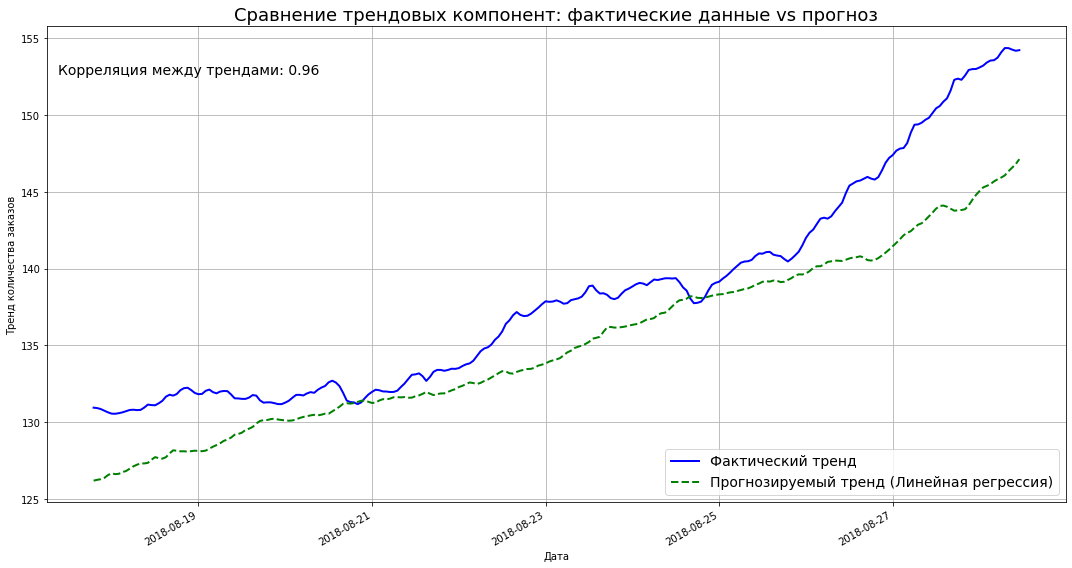

In [96]:
actual_trend = seasonal_decompose(y_test, period=24*7).trend
predicted_trend = seasonal_decompose(pd.Series(
    best_model.predict(X_test), index=y_test.index), period=24*7).trend

plt.figure(figsize=(15, 8))
plt.plot(actual_trend.index, actual_trend, 
         label='Фактический тренд', color='blue', linewidth=2)
plt.plot(predicted_trend.index, predicted_trend, 
         label='Прогнозируемый тренд (Линейная регрессия)', color='green', linestyle='--', linewidth=2)
plt.title('Сравнение трендовых компонент: фактические данные vs прогноз', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Тренд количества заказов')
plt.legend(loc='lower right', fontsize=14)
plt.grid()

plt.annotate(f'Корреляция между трендами: {actual_trend.corr(predicted_trend):.2f}',
             xy=(0.01, 0.9), xycoords='axes fraction', fontsize=14)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

## Выводы.

1. Загружены данные
    - данные размером (26496, 2)
    - нет пропусков
    - данные отсортированы по увеличению индекса
    - столбец `datetime` - дата заказа, тип данных object. 
    - столбец `num_orders` - количество заказов, тип данных int64
2. Проведена обработка и ресемплирование
    - `datetime` - данные переведены в формат datetime.
    - установлен индекс `datetime`
    - индекс отсортирован на увеличение
    - данные проверены на монотонность
    - ресемплинг данных на 1 час
    - новый размер данных (4416, 1), индекс дата
3. На основе анализа данных были выявлены:
    - временной ряд не стационарный (увеличение среднего и отклонения к концу периода)
    - явный восходящий тренд на увеличение количества заказов с марта по август
    - сезонный компонент: увеличение количества заказов с 6:00 до 00:00 с дальнейшим резким падением.
4. Для целей моделирования были созданы новые признаки
    - из даты выделены `['hour', 'dayofweek', 'day', 'month', 'weekofyear']`
    - сместили ряд на: `[1, 2, 3, 24, 48, 24*7]`
    - добавили скользящие средние: `[3, 7, 24, 24*7]`
5. Обучили три модели
    - LinearRegression
    - RandomForestRegressor
    - LGBMRegressor
    - Лучший результат LinearRegression с `RMSE на кросс-валидации: 21.70`
6. Запустили лучшую модель на тесте и проверили на адекватность
    - `RMSE на тестовой выборке: 35.80`
    - `Dummy(mean) модель:      79.56`
7. Рекомендовано использовать модель Линейной регрессии для прогнозирования количества заказов на следующий час.